# Вебинар 6. Двухуровневые модели рекомендаций


### Зачем 2 уровня?
- Классические модели классификации (lightgbm) зачастую работают лучше, чем рекоммендательные модели (als, lightfm)
- Данных много, предсказаний много (# items * # users) --> с таким объемом lightgbm не справляется
- Но рекомендательные модели справляются!

Отбираем top-N (200) *кандидатов* с помощью простой модели (als) --> переранжируем их сложной моделью (lightgbm)
и выберем top-k (10).

---

### Как отбирать кандидатов?

Вариантов множество. Тут нам поможет *MainRecommender*. Пока в нем реализованы далеко не все возможные способы генерации кандидатов

- Генерируем топ-k кандидатов
- Качество кандидатов измеряем через **recall@k**
- recall@k показывает какую долю из купленных товаров мы смогли выявить (рекомендовать) нашей моделью

----

# Практическая часть

# Import libs

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Read data

In [5]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# Process features dataset

In [6]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [7]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [8]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [9]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [10]:
def print_stats_data(df_data, name_df):
    print(f'{name_df}:')
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}\n")

In [11]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher:
Shape: (2108779, 12) Users: 2498 Items: 83685

val_matcher:
Shape: (169711, 12) Users: 2154 Items: 27649

train_ranker:
Shape: (169711, 12) Users: 2154 Items: 27649

val_ranker:
Shape: (118314, 12) Users: 2042 Items: 24329



In [12]:
# выше видим разброс по пользователям и товарам

In [13]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [14]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [15]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher:
Shape: (861404, 13) Users: 2495 Items: 5001

val_matcher:
Shape: (169615, 12) Users: 2151 Items: 27644

train_ranker:
Shape: (169615, 12) Users: 2151 Items: 27644

val_ranker:
Shape: (118282, 12) Users: 2040 Items: 24325



In [16]:
# Теперь warm-start по пользователям

# Init/train recommender

In [17]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [18]:
# Берем тестового юзера 2375

In [19]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1106523, 1044078, 871756, 5569230]

In [20]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [21]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 937292, 842125, 15778319]

In [22]:
# recommender.get_similar_users_recommendation(2375, N=5)

# Eval recall of matching

### Измеряем recall@k

Это будет в ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [23]:
ACTUAL_COL = 'actual'

In [24]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [25]:
# N = Neighbors
N_PREDICT = 50 

In [26]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].\
                                    apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].\
                                    apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))

result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].\
                                    apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

CPU times: user 1min 5s, sys: 1.72 s, total: 1min 7s
Wall time: 22.3 s


In [27]:
# %%time
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].\
#                                        apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [28]:
result_eval_matcher.head(2)

,user_id,actual,own_rec,sim_item_rec,als_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[839818, 1007512, 9297615, 5577022, 1132231, 9...","[1082212, 891118, 1055425, 920200, 9364612, 80..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[1137346, 5569845, 1044078, 985999, 880888, 81...","[5569230, 916122, 1101822, 1029743, 10150194, ..."


### Пример оборачивания

In [29]:
# # сырой и простой пример как можно обернуть в функцию
def evalRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [30]:
# evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)

In [31]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [32]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.\
                            apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [33]:
TOPK_RECALL = 50

In [34]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.04785879593594856),
 ('sim_item_rec', 0.033909931616886275)]

### Precision@5 of matching

In [35]:
TOPK_PRECISION = 5

In [36]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.17712691771268974),
 ('als_rec', 0.1169688516968841),
 ('sim_item_rec', 0.06266852626685294)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [37]:
# 3 временных интервала
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

## Подготовка данных для трейна

In [38]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [39]:
%%time
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].\
                                        apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 5.51 s, sys: 480 ms, total: 6 s
Wall time: 6 s


In [40]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [41]:
df_items = df_match_candidates.\
                apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [42]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [43]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


### Check warm start

In [44]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates:
Shape: (107550, 2) Users: 2151 Items: 4574



### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [45]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [46]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [47]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [48]:
df_ranker_train.target.value_counts()

0.0    99177
1.0     7795
Name: target, dtype: int64

In [49]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


(!) На каждого юзера 50 item_id-кандидатов

In [50]:
df_ranker_train['target'].mean()

0.07286953595333358

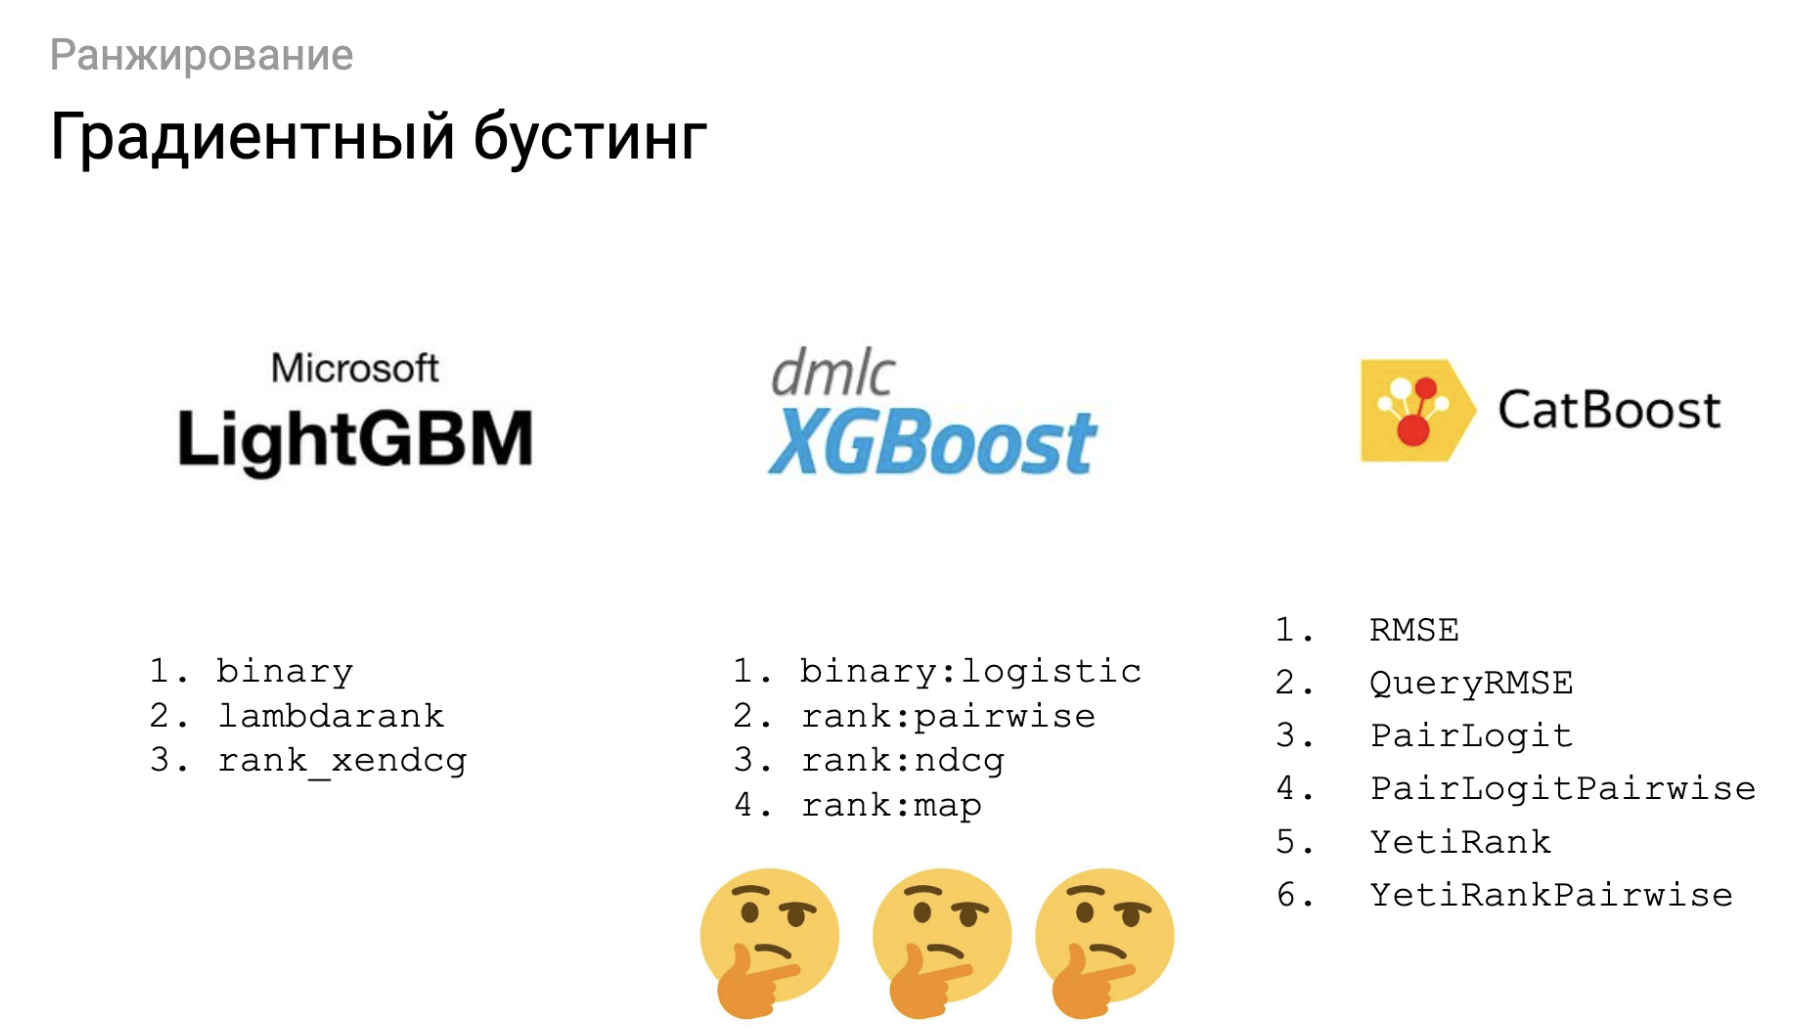

Слайд из [презентации](https://github.com/aprotopopov/retailhero_recommender/blob/master/slides/retailhero_recommender.pdf) решения 2-ого места X5 Retail Hero

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

## Подготавливаем фичи для обучения модели

In [51]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [52]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [53]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [54]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [55]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [56]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

## Обучение модели ранжирования

In [57]:
# делали на вебинаре, кусок с катбустом

# from catboost import CatBoost, Pool

# df_bin_feat = pd.get_dummies(X_train)

# model = CatBoost(params ={'objective': "Logloss",
#                           "iterations":1000,
#                           "max_depth":8,
#                           "task_type":"GPU",
#                           "devices":"0:1:2:3"
#             })
# model.fit(df_bin_juice, y_train, silent=True)

# train_preds = model.predict(df_bin_feat,prediction_type="Probability")

In [58]:
%%time
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats,
                     n_jobs=-1,
#                      verbose=0
                   )

lgb.fit(X_train, y_train['target'])

train_preds = lgb.predict_proba(X_train)

CPU times: user 10.6 s, sys: 125 ms, total: 10.7 s
Wall time: 1.45 s


In [59]:
df_ranker_predict = df_ranker_train.copy()

In [60]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [61]:
df_ranker_predict['proba_item_purchase'][:10]

0    0.036421
1    0.022789
2    0.034224
3    0.000956
4    0.296946
5    0.041391
6    0.086421
7    0.002064
8    0.082280
9    0.469736
Name: proba_item_purchase, dtype: float64

## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [62]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [63]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].\
                                    apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 5.14 s, sys: 330 ms, total: 5.47 s
Wall time: 5.47 s


In [64]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [65]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].\
                sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [66]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [67]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15331592689294912)
('own_rec', 0.1444117647058813)


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

In [68]:
result_eval_ranker.head(3)

,user_id,actual,own_rec,reranked_own_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[9655212, 8293439, 8091601, 1082269, 992986]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1092937, 1008714, 12132312, 1075979, 998206, ...",[]
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13003092, 972416, 995598, 923600, 1138596, 10...","[900802, 12757544, 1098844, 897088, 6979393]"


# Домашнее задание

### Задание 1.


#### A) 

Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

**Ответ:**

Не совсем понял зачем это давать в ДЗ, если уже в методичке это было проверено. Лучший рекол дает Own_recommend.

In [69]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.04785879593594856),
 ('sim_item_rec', 0.033909931616886275)]

Посмотрим на recall top-popular:

In [70]:
result_eval_matcher['top_rec'] = result_eval_matcher[USER_COL].\
                                    apply(lambda x: recommender.overall_top_purchases[:N_PREDICT])

In [71]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.04785879593594856),
 ('top_rec', 0.04323684353105271),
 ('sim_item_rec', 0.033909931616886275)]

На удивление не плохой recall. 

А теперь объеденим own recommendtions + top-popular в соотношении 1:1

In [72]:
result_eval_matcher['own_top_rec'] = result_eval_matcher[USER_COL].\
                                    apply(lambda x: recommender.get_own_recommendations(x, N = int(N_PREDICT / 2)) +\
                                                    recommender.overall_top_purchases[:int(N_PREDICT / 2)])

In [73]:
result_eval_matcher.head(2)

,user_id,actual,own_rec,sim_item_rec,als_rec,top_rec,own_top_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[839818, 1007512, 9297615, 5577022, 1132231, 9...","[1082212, 891118, 1055425, 920200, 9364612, 80...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[1137346, 5569845, 1044078, 985999, 880888, 81...","[5569230, 916122, 1101822, 1029743, 10150194, ...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[911974, 1076580, 1103898, 5567582, 1056620, 9..."


In [74]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_top_rec', 0.07259911763287853),
 ('own_rec', 0.06525657038145175),
 ('als_rec', 0.04785879593594856),
 ('top_rec', 0.04323684353105271),
 ('sim_item_rec', 0.033909931616886275)]

Очень интересный результат. Оставим пока его для размышлений.

---

#### B)

* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

Для проверки возьмем чистый own_rec:

In [75]:
top_k_recs = [20, 50, 100, 200, 500]

In [76]:
%%time

for k in top_k_recs:
    name_col = 'own_rec_' + str(k)
    result_eval_matcher[name_col] = result_eval_matcher[USER_COL].\
                                    apply(lambda x: recommender.get_own_recommendations(x, N = k))

CPU times: user 26.2 s, sys: 105 ms, total: 26.3 s
Wall time: 26.3 s


In [77]:
result_eval_matcher.head(2)

,user_id,actual,own_rec,sim_item_rec,als_rec,top_rec,own_top_rec,own_rec_20,own_rec_50,own_rec_100,own_rec_200,own_rec_500
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[839818, 1007512, 9297615, 5577022, 1132231, 9...","[1082212, 891118, 1055425, 920200, 9364612, 80...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[1137346, 5569845, 1044078, 985999, 880888, 81...","[5569230, 916122, 1101822, 1029743, 10150194, ...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9..."


Посчитаем Recall для каждого top:

In [78]:
own_recalls = []

for k in top_k_recs:
    name_col = 'own_rec_' + str(k)
    own_recalls.append(*(calc_recall(result_eval_matcher[['user_id', 'actual', name_col]], k)))

own_recalls = sorted(own_recalls, key=lambda x: x[1], reverse=True)
own_recalls

[('own_rec_500', 0.18205324555508678),
 ('own_rec_200', 0.13537278412833242),
 ('own_rec_100', 0.09604492955885034),
 ('own_rec_50', 0.06525657038145175),
 ('own_rec_20', 0.03928427679372909)]

In [79]:
own_recalls_k = []
for rec in own_recalls[::-1]:
    own_recalls_k.append(rec[1])
own_recalls_k

[0.03928427679372909,
 0.06525657038145175,
 0.09604492955885034,
 0.13537278412833242,
 0.18205324555508678]

In [80]:
from matplotlib import pyplot as plt

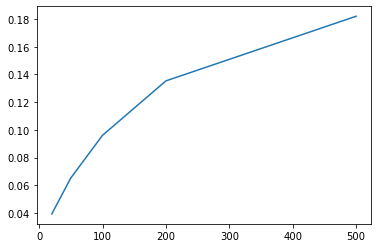

In [81]:
plt.plot(top_k_recs, own_recalls_k)
plt.show()

Максимальный recall получаем при k=500. 

Возможно это из-за того, что чем больше k тем больше в рекомендации подмешивается top-popular. Попробуем проверить эту гипотезу: 

In [82]:
result_eval_matcher['own_top_rec_500'] = result_eval_matcher[USER_COL].\
                                    apply(lambda x: recommender.get_own_recommendations(x, N = int(500 / 2)) +\
                                                    recommender.overall_top_purchases[:int(500 / 2)])

In [83]:
list(calc_recall(result_eval_matcher[['user_id', 'actual', 'own_rec_500', 'own_top_rec_500']], 500))

[('own_rec_500', 0.18205324555508678),
 ('own_top_rec_500', 0.16886001315773422)]

Хм, нет. При обычном own_rec результат лучше.

Проверим что будет если дальше увеличивать k:

In [84]:
%%time

for k in [750, 1000, 1500, 2000]:
    name_col = 'own_rec_' + str(k)
    result_eval_matcher[name_col] = result_eval_matcher[USER_COL].\
                                    apply(lambda x: recommender.get_own_recommendations(x, N = k))

CPU times: user 21.3 s, sys: 127 ms, total: 21.4 s
Wall time: 21.5 s


In [85]:
own_recalls = []

for k in [750, 1000, 1500, 2000]:
    name_col = 'own_rec_' + str(k)
    own_recalls.append(*(calc_recall(result_eval_matcher[['user_id', 'actual', name_col]], k)))

own_recalls = sorted(own_recalls, key=lambda x: x[1], reverse=True)
own_recalls

[('own_rec_2000', 0.25405426272154885),
 ('own_rec_1500', 0.23898784772021095),
 ('own_rec_1000', 0.21679061833967822),
 ('own_rec_750', 0.20041247093594652)]

---

#### C)

* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

После k=200 рост recall незначительный, поэтому более разумным будет не использовать k > 200. 

### Задание 2.

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

Для начала возьмем новую модель CatBoost и подберем параметры:

In [86]:
X_train.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [87]:
X_train[cat_feats].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106972 entries, 0 to 106971
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   manufacturer          106972 non-null  category
 1   department            106972 non-null  category
 2   brand                 106972 non-null  category
 3   commodity_desc        106972 non-null  category
 4   sub_commodity_desc    106972 non-null  category
 5   curr_size_of_product  106972 non-null  category
 6   age_desc              39519 non-null   category
 7   marital_status_code   39519 non-null   category
 8   income_desc           39519 non-null   category
 9   homeowner_desc        39519 non-null   category
 10  hh_comp_desc          39519 non-null   category
 11  household_size_desc   39519 non-null   category
 12  kid_category_desc     39519 non-null   category
dtypes: category(13)
memory usage: 2.7 MB


Для работы CatBoost надо обработать категориальные параметры и убрать Null из датасета:

In [88]:
# сначала снимем тип "категория" для возможности внесения изменений
X_train[cat_feats] = X_train[cat_feats].astype('object')

In [89]:
X_train[cat_feats] = X_train[cat_feats].fillna('')

In [90]:
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [91]:
from catboost import CatBoost

In [227]:
%%time

model = CatBoost(params ={'objective': "Logloss",
                          "iterations":500,  # n_estimators
                          "max_depth":8,
                        })

model.fit(X_train, y_train, silent=True, cat_features=cat_feats)

train_preds = model.predict(X_train, prediction_type="Probability")

CPU times: user 4min 53s, sys: 7.32 s, total: 5min
Wall time: 46.8 s


In [228]:
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]
df_ranker_predict['proba_item_purchase'][:10]

0    0.033069
1    0.041322
2    0.044243
3    0.011221
4    0.228123
5    0.065380
6    0.046014
7    0.022455
8    0.059474
9    0.139695
Name: proba_item_purchase, dtype: float64

In [229]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [230]:
N_PREDICT = 200

In [231]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].\
                                    apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 5.28 s, sys: 299 ms, total: 5.58 s
Wall time: 5.59 s


In [232]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [233]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('own_rec', 0.1444117647058813)
('reranked_own_rec', 0.13848563968668315)


Что-то результат не очень. Попробуем Grid Search

In [99]:
import itertools

In [234]:
param_grid = {'objective': ["Logloss", "RMSE", "Poisson"], 
              'max_depth': [4, 6, 8], 
              'iterations': [1000], 
             }

In [235]:
%%time

precisions = []
best_params = {}
best_precision = 0
keys, values = zip(*param_grid.items())

for val in itertools.product(*values):    
    # Set new attributes for model   
    params = dict(zip(keys, val))
    model = CatBoost(params=params)
    
    model.fit(X_train, y_train, silent=True, cat_features=cat_feats)

    train_preds = model.predict(X_train, prediction_type="Probability")
    
    # rewrite score column
    df_ranker_predict['proba_item_purchase'] = train_preds[:,1]
    
    # make rerunk row    
    result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))
    
    # evaluate precision at k
    precision_score = list(calc_precision(result_eval_ranker[['user_id', 'actual', 'reranked_own_rec']],
                                                              TOPK_PRECISION))[0][1]
    
    # for log
    precisions.append(precision_score)
    
    # check and rewrite best params
    if precision_score > best_precision:
        best_precision = precision_score
        best_params = params

print(f'best_params: {best_params}')
print(f'best_precision: {best_precision}')

best_params: {'objective': 'Logloss', 'max_depth': 8, 'iterations': 1000}
best_precision: 0.14642297650130423
CPU times: user 59min 51s, sys: 54.8 s, total: 1h 46s
Wall time: 9min 27s


In [236]:
metric_df = pd.DataFrame(itertools.product(*values), columns=keys)
metric_df['precision'] = precisions
metric_df.sort_values(by='precision', ascending=False)

,objective,max_depth,iterations,precision
2,Logloss,8,1000,0.146423
1,Logloss,6,1000,0.145692
5,RMSE,8,1000,0.145065
4,RMSE,6,1000,0.141410
8,Poisson,8,1000,0.140052
3,RMSE,4,1000,0.137441
7,Poisson,6,1000,0.136710
0,Logloss,4,1000,0.136501
6,Poisson,4,1000,0.131384


Уже лучше чем own_rec, но все равно хуже чем LightGBM. 

#### - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

Добавим фичу `Средний чек`:

In [240]:
X_train['mean_receipt'] = X_train.merge(data.groupby(by='user_id', as_index=False)[['sales_value']].mean(), 
                                                     on='user_id', 
                                                     how='left')['sales_value']

Добавим фичу `Кол-во покупок в каждой категории`:

In [241]:
# Создадим временный датафрейм для удобства подсчета метрик
df = data.merge(item_features, on='item_id', how='left')
df.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,2,PRODUCE,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB


In [242]:
X_train['mean_quantity_department'] = X_train.merge(df.groupby(by=['user_id', 'department'],
                                                               as_index=False)[['quantity']].sum(), 
                                                    on=['user_id', 'department'], 
                                                    how='left')['quantity']

In [243]:
X_train.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_receipt,mean_quantity_department
0,2070,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,24.0
1,2070,1097350,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,2216.0


**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    

Добавим фичу `Кол-во покупок в неделю`:

In [244]:
# Так как товар продается не каждую неделю, то нужно делить на кол-во недель
X_train['item_quantity_per_week'] = X_train.merge(df.groupby(by='item_id',
                                                             as_index=False)[['quantity']].sum(), 
                                                    on='item_id', 
                                                    how='left')['quantity'] / 95

Добавим фичу `Цена`:

In [245]:
# Для корректности расчета отфильтируем по количеству продаж
X_train['item_price'] = X_train.merge(df[df['quantity'] == 1].groupby(by='item_id', 
                                                                      as_index=False)[['sales_value']].mean(), 
                                                    on='item_id', 
                                                    how='left')['sales_value']

In [246]:
X_train.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_receipt,mean_quantity_department,item_quantity_per_week,item_price
0,2070,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,24.0,1.242105,3.918810
1,2070,1097350,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,2216.0,0.568421,11.448333


**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

Добавим фичу `Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)`:

In [247]:
X_train['mean_purchase'] = X_train.merge(df[df['quantity'] == 1].groupby(by=['user_id','item_id'], 
                                                          as_index=False)[['sales_value']].mean(),
                          on=['user_id','item_id'],
                          how='left')['sales_value']

Добавим фичу `Кол-во покупок юзером конкретной категории в неделю`:

In [248]:
X_train['quantity_purchase_per_week'] = X_train.merge(df.groupby(by=['user_id','item_id'], 
                                                                 as_index=False)[['quantity']].sum(),
                                                      on=['user_id','item_id'],
                                                      how='left')['quantity'] / 95

Посмотрим какое заполнение у нас получилось:

In [249]:
X_train.iloc[:, 15:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106972 entries, 0 to 106971
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   mean_receipt                106972 non-null  float64
 1   mean_quantity_department    105553 non-null  float64
 2   item_quantity_per_week      106972 non-null  float64
 3   item_price                  106969 non-null  float64
 4   mean_purchase               81759 non-null   float64
 5   quantity_purchase_per_week  87816 non-null   float64
dtypes: float64(6)
memory usage: 5.7 MB


Фичи user-item заполнены примерно на 80%. Оно и понятно, парная группировка более редкие данные дает.

Заполним пропуски:

In [250]:
X_train.iloc[:, 15:] = X_train.iloc[:, 15:].fillna(0)

#### - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

обучим модели LightLGB и CatBoost:

In [259]:
%%time
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats,
                     n_jobs=-1,
#                      verbose=0
                   )

lgb.fit(X_train, y_train['target'])

train_preds = lgb.predict_proba(X_train)

CPU times: user 14.3 s, sys: 283 ms, total: 14.6 s
Wall time: 2.05 s


In [260]:
# rewrite score column
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

# make rerunk row    
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [261]:
# evaluate precision at k
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.2725848563968651)
('own_rec', 0.1444117647058813)


In [254]:
%%time
model = CatBoost(params=best_params)
    
model.fit(X_train, y_train, silent=True, cat_features=cat_feats)

train_preds = model.predict(X_train, prediction_type="Probability")

CPU times: user 10min 30s, sys: 18.9 s, total: 10min 49s
Wall time: 1min 40s


In [255]:
# rewrite score column
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

# make rerunk row    
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [258]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.28563968668407175)
('own_rec', 0.1444117647058813)


#### - Вырос ли precision@5 при использовании двухуровневой модели?

Да, с добавлением фич произошел значительный рост метрики. Также CatBoost с фичами показал себя лучше, чем LightGBM.